In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
mpl.style.use("ggplot")
import warnings
warnings.filterwarnings('ignore')
import re

In [2]:
train=pd.read_csv('data/titanic/train.csv')
test=pd.read_csv('data/titanic/test.csv')
passengerId=test['PassengerId']
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
for dataset in full_data:
    dataset['Name_length'] = dataset['Name'].apply(len)
    dataset['Has_Cabin'] = dataset["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.IsAlone[dataset['FamilySize'] == 1] = 1
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)


In [12]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


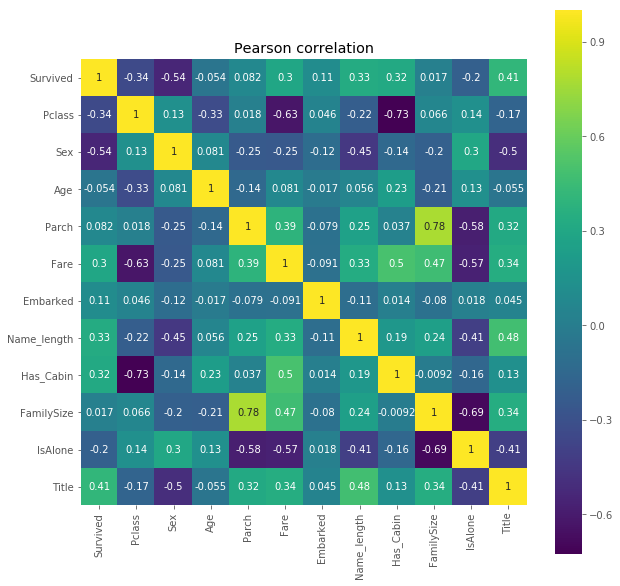

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(),square=True, annot=True, linecolor='white',cmap=plt.cm.viridis ).set_title('Pearson correlation')

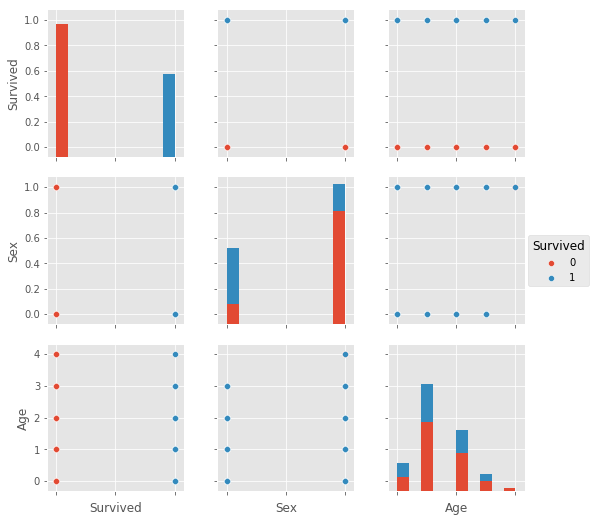

In [13]:
#g=sns.pairplot(train[['Survived','Sex','Age']],diag_kind='kde', hue='Survived')


g=sns.pairplot(train[['Survived','Sex','Age']], hue='Survived')
g.set(xticklabels=[])


In [14]:
from sklearn.model_selection import KFold, StratifiedKFold,StratifiedShuffleSplit

In [16]:
kd=KFold(n_splits=3)
list(kd.split(np.arange(10)))

[(array([4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3])),
 (array([0, 1, 2, 3, 7, 8, 9]), array([4, 5, 6])),
 (array([0, 1, 2, 3, 4, 5, 6]), array([7, 8, 9]))]

In [17]:
list(kd.split(np.arange(11)))

[(array([ 4,  5,  6,  7,  8,  9, 10]), array([0, 1, 2, 3])),
 (array([ 0,  1,  2,  3,  8,  9, 10]), array([4, 5, 6, 7])),
 (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 8,  9, 10]))]

In [20]:
x=np.arange(20)
y=np.random.randint(1,4,20)
y

array([1, 2, 2, 3, 1, 2, 3, 3, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 3, 2])

In [21]:
sk=StratifiedKFold(n_splits=3)
list(sk.split(x,y))

[(array([ 4,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
  array([0, 1, 2, 3, 5, 6, 7, 8])),
 (array([ 0,  1,  2,  3,  5,  6,  7,  8, 14, 16, 17, 18, 19]),
  array([ 4,  9, 10, 11, 12, 13, 15])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15]),
  array([14, 16, 17, 18, 19]))]

In [26]:
sk=StratifiedKFold(n_splits=4)
list(sk.split(x,y))

[(array([ 4,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
  array([0, 1, 2, 3, 5, 6])),
 (array([ 0,  1,  2,  3,  5,  6, 11, 13, 14, 15, 16, 17, 18, 19]),
  array([ 4,  7,  8,  9, 10, 12])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 17, 18, 19]),
  array([11, 13, 14, 15, 16])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
  array([17, 18, 19]))]

In [24]:
sss=StratifiedShuffleSplit(n_splits=4, test_size=0.3)
list(sss.split(x,y))

[(array([ 1, 15, 14, 17,  6,  0, 10,  2, 13,  7, 11, 12,  9, 19]),
  array([ 3,  4, 16,  8, 18,  5])),
 (array([ 3,  5,  8, 19, 18, 16,  9,  2,  4, 12,  1, 11,  7, 13]),
  array([14, 15,  0, 10,  6, 17])),
 (array([15, 11,  6,  3, 13,  4, 12, 10, 19,  7,  9, 16, 17,  8]),
  array([ 5, 14,  2,  1,  0, 18])),
 (array([ 8, 12, 16,  2,  6,  9, 18, 14, 15,  0, 17,  1, 10,  7]),
  array([ 4, 19, 13,  5, 11,  3]))]

In [62]:
class sklearnhelper(object):
    def __init__(self, clf, params=None):
        params['random_state']=0
        self.clf=clf(**params)
    def fit(self, x, y):
        self.clf.fit(x,y)
    def predict(self,x):
        return self.clf.predict(x)
    def feature_importance(self):
        return self.clf.feature_importances_

In [37]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [31]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

In [38]:
rf=sklearnhelper(RandomForestClassifier, params=rf_params)
ex=sklearnhelper(ExtraTreesClassifier,params=et_params)
ada=sklearnhelper(AdaBoostClassifier, params=ada_params)
gb=sklearnhelper(GradientBoostingClassifier, params=gb_params)
svc=sklearnhelper(SVC, params=svc_params)

In [52]:
y_train=train.Survived.values
x_train=train.drop(['Survived'],axis=1).values
x_test=test.values

In [45]:
np.zeros((10,1))

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [27]:
ntrain=train.shape[0]
ntest=test.shape[0]
kf=KFold(n_splits=5, random_state=0)

In [54]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train=np.zeros(ntrain)
    oof_test=np.zeros(ntest)
    oof_test_skf=np.zeros((5, ntest)) # 5 is the number of folds
    
    for i, (train_index, test_index) in enumerate(kf.split(np.arange(ntrain))):
        x_tr, y_tr=x_train[train_index], y_train[train_index]
        x_te=x_train[test_index]
        clf.fit(x_tr, y_tr)
        oof_train[test_index]=clf.predict(x_te)
        oof_test_skf[i,:]=clf.predict(x_test)
    
    oof_test=np.mean(oof_test_skf,axis=0)
    return oof_train.reshape(-1,1),oof_test.reshape(-1,1)

In [55]:
ex_oof_train, et_oof_test = get_oof(ex, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

In [64]:
rf.fit(x_train, y_train)
rf_feature = rf.feature_importance()

ex.fit(x_train, y_train)
ex_feature = ex.feature_importance()

ada.fit(x_train, y_train)
ada_feature = ada.feature_importance()

gb.fit(x_train, y_train)
gb_feature = gb.feature_importance()

In [65]:
rf_feature

array([ 0.126054  ,  0.19797221,  0.02897303,  0.02108006,  0.07136782,
        0.02467553,  0.11080384,  0.06479138,  0.06624415,  0.01368605,
        0.27435193])

In [80]:
importances=pd.DataFrame({'features':train.columns[1:],
                          'ExtraTree':ex_feature,
                          'RandomForest':rf_feature,
                          'Adaboost':ada_feature,
                          'GradientBoosting':gb_feature
                         })
importances

,Adaboost,ExtraTree,GradientBoosting,RandomForest,features
0,0.030,0.120744,0.067928,0.126054,Pclass
1,0.012,0.380900,0.035990,0.197972,Sex
2,0.022,0.027188,0.109401,0.028973,Age
3,0.062,0.016802,0.029935,0.021080,Parch
4,0.038,0.056344,0.094005,0.071368,Fare
5,0.010,0.028738,0.046040,0.024676,Embarked
6,0.690,0.046790,0.415312,0.110804,Name_length
7,0.014,0.082037,0.014308,0.064791,Has_Cabin
8,0.052,0.044783,0.067437,0.066244,FamilySize
9,0.002,0.022082,0.027582,0.013686,IsAlone


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

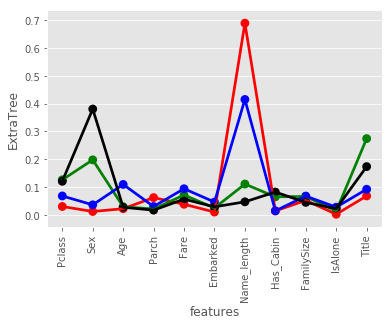

In [89]:
sns.pointplot('features','Adaboost',data=importances, color='r')
sns.pointplot('features','RandomForest',data=importances,color='g')
sns.pointplot('features','GradientBoosting',data=importances,color='b')
sns.pointplot('features','ExtraTree',data=importances,color='k')
plt.xticks(rotation=90)

In [92]:
mean_value=importances.mean(axis=1)
mean_value

0     0.086181
1     0.156716
2     0.046891
3     0.032454
4     0.064929
5     0.027363
6     0.315726
7     0.043784
8     0.057616
9     0.016337
10    0.152001
dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

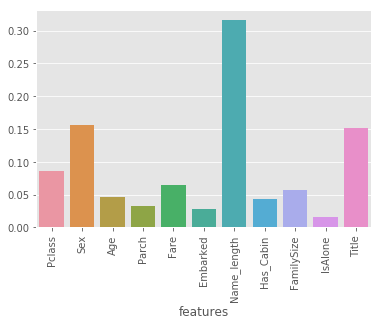

In [94]:
sns.barplot(importances.features, mean_value)
plt.xticks(rotation=90)

In [101]:
ada_oof_train.reshape(1,-1)

array([[ 0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,
         1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
         1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.

In [102]:
ada_oof_train.ravel()

array([ 0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,
        0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
        1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0

In [103]:
base_prediction_train=pd.DataFrame({'Adaboost':ada_oof_train.ravel(),
                                    'ExtraTree': ex_oof_train.ravel(),
                                    'RandomForest':rf_oof_train.ravel(),
                                    'GradientBoosting':gb_oof_train.ravel()
                                   })
base_prediction_train.head()

,Adaboost,ExtraTree,GradientBoosting,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


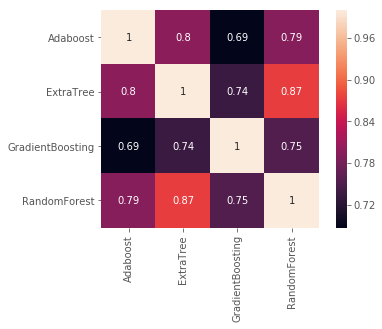

In [106]:
sns.heatmap(base_prediction_train.corr(),square=True, annot=True)

In [115]:
print(type(ada_oof_train))
ada_oof_train.shape

<class 'numpy.ndarray'>


(891, 1)

In [114]:
stack_x_train=np.concatenate((ada_oof_train,ex_oof_train,rf_oof_train,gb_oof_train,svc_oof_train),axis=1)
stack_x_test=np.concatenate((ada_oof_test, et_oof_test, rf_oof_test,gb_oof_test,svc_oof_test),axis=1)

In [116]:
stack_x_train

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  0.,  1.,  1.,  1.],
       ..., 
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [119]:
import xgboost as xgb


gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 200,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(stack_x_train, y_train)

predictions = gbm.predict(stack_x_test)



ModuleNotFoundError: No module named 'xgboost'